<a href="https://colab.research.google.com/github/tmoore-byte/350A3/blob/master/Project_4_393.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**GAN's and AEs for Data Augmentation**

Thomas Moore

2318524

In [69]:
# Testing cnn from ica on the MNIST dataset
# loading libraries
import numpy as np
from tensorflow import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Flatten
from keras.layers.convolutional import Conv2D
# from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from keras.layers.pooling import MaxPooling2D
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
# to make the example replicable
np.random.seed(42)
# Load of the dataset
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

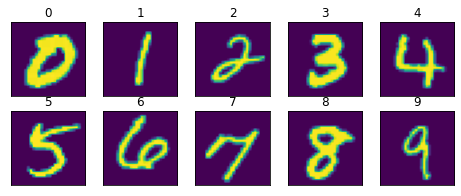

In [70]:
import matplotlib.pyplot as plt
class_names = ['0','1','2','3','4',
               '5','6','7','8','9']
fig = plt.figure(figsize=(8,3))
for i in range(len(class_names)):
  ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
  idx = np.where(Y_train[:]==i)[0]
  features_idx = X_train[idx,::]
  img_num = np.random.randint(features_idx.shape[0])
  im = features_idx[img_num,::]
  ax.set_title(class_names[i])
  #im = np.transpose(features_idx[img_num,::], (1, 2, 0))
  plt.imshow(im)
plt.show()

In [71]:
#print("y train: ", Y_train)
#print("x train: ", X_train)
#print("y test: ", Y_test)
#print("x test: ", X_test)

In [72]:
sample_shape = X_train[0].shape
img_width, img_height = sample_shape[0], sample_shape[1]
input_shape = (img_width, img_height, 1)

In [73]:
# reshaping
X_train = X_train.reshape(len(X_train),
                          input_shape[0],
                          input_shape[1],
                          input_shape[2])
X_test  = X_test.reshape(len(X_test),
                         input_shape[0],
                         input_shape[1],
                         input_shape[2])

In [74]:
# Initializing the model
model = Sequential()


# Defining a convolutional layer
model.add(Conv2D(50, kernel_size=(3, 3), activation='relu',
                 input_shape=(28, 28, 1)))


# Defining a second convolutional layer
model.add(Conv2D(50, kernel_size=(3, 3), activation='relu'))


# Defining a third convolutional layer
model.add(Conv2D(50, kernel_size=(3, 3), activation='relu'))


# We add our classificator
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(10, activation='softmax'))


# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001, decay=1e-6),
              metrics=['accuracy'])


# Training of the model
model.fit(X_train, to_categorical(Y_train),
          batch_size=50,
          shuffle=True,
          epochs=3,
          validation_data=(X_test, to_categorical(Y_test)))


# Evaluation of the model
scores = model.evaluate(X_test, to_categorical(Y_test))
print('Loss: %.3f' % scores[0])
print('Accuracy: %.3f' % scores[1])


Epoch 1/3
1200/1200 [==============================] - 455s 379ms/step - loss: 0.2170 - accuracy: 0.9550 - val_loss: 0.0462 - val_accuracy: 0.9847
Epoch 2/3
1200/1200 [==============================] - 452s 377ms/step - loss: 0.0264 - accuracy: 0.9917 - val_loss: 0.0436 - val_accuracy: 0.9863
Epoch 3/3
313/313 [==============================] - 20s 63ms/step - loss: 0.0504 - accuracy: 0.9849
Loss: 0.050
Accuracy: 0.985


**GAN for MNIST data augmentation**

In [75]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model

In [76]:
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(64,
                     (3,3),
                     strides=(2, 2),
                     padding='same',
                     input_shape=in_shape))
    
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64,
                     (3,3),
                     strides=(2, 2),
                     padding='same'))
    
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    opt = Adam(learning_rate=0.0002, beta_1=0.5)

    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

In [77]:
model = define_discriminator()
model.summary()


Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_35 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 3136)            

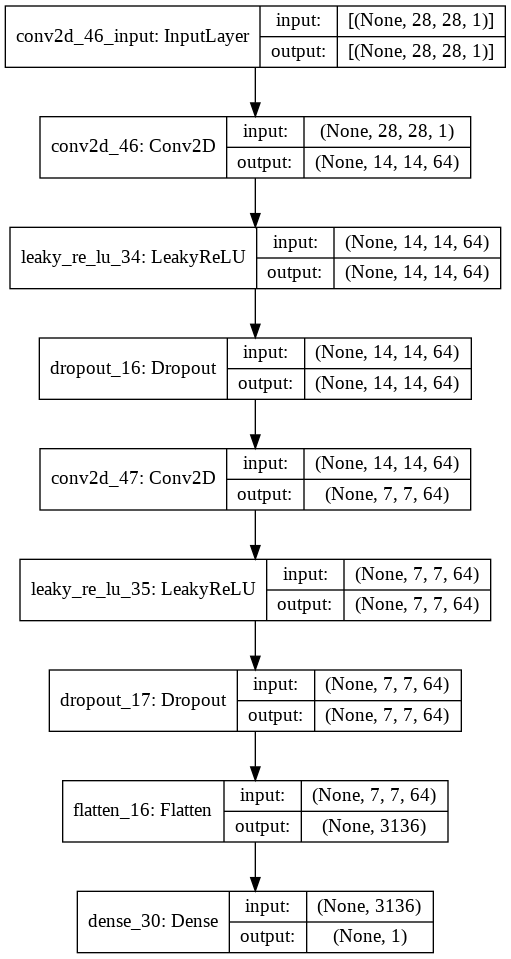

In [78]:
plot_model(model, to_file='discriminator_plot.png',
           show_shapes=True,
           show_layer_names=True)

In [79]:
from random import randint
from numpy import ones
from numpy import zeros

(trainX, _), (_, _) = mnist.load_data()
X = np.expand_dims(trainX, axis=-1)

X = X.astype('float32')
X = X / 255.0

In [80]:
def load_real_samples():
    (trainX, _), (_, _) = mnist.load_data()
    X = np.expand_dims(trainX, axis=-1)
    X = X.astype('float32')
    X = X / 255.0
    return X

def generate_real_samples(dataset, n_samples):
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = np.ones((n_samples, 1))
    return X, y


def generate_fake_samples(n_samples):
    X = np.random.rand(28 * 28 * n_samples)
    X = X.reshape((n_samples, 28, 28, 1))
    y = np.zeros((n_samples, 1))
    return X, y

In [81]:
# training discriminator

def train_discriminator(model, dataset, n_iter=100, n_batch=256):
    half_batch = int(n_batch / 2)
    for i in range(n_iter):
        X_real, y_real = generate_real_samples(dataset, half_batch)
        _, real_acc = model.train_on_batch(X_real, y_real)
        X_fake, y_fake = generate_fake_samples(half_batch)
        _, fake_acc = model.train_on_batch(X_fake, y_fake)
        print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100,
                                               fake_acc*100))

In [82]:
model = define_discriminator()
dataset = load_real_samples()
train_discriminator(model, dataset)

>1 real=20% fake=83%
>2 real=20% fake=85%
>3 real=25% fake=98%
>4 real=19% fake=98%
>5 real=31% fake=98%
>6 real=23% fake=100%
>7 real=27% fake=100%
>8 real=34% fake=100%
>9 real=36% fake=100%
>10 real=34% fake=100%
>11 real=41% fake=100%
>12 real=35% fake=100%
>13 real=38% fake=100%
>14 real=45% fake=100%
>15 real=42% fake=100%
>16 real=55% fake=100%
>17 real=49% fake=100%
>18 real=58% fake=100%
>19 real=64% fake=100%
>20 real=68% fake=100%
>21 real=66% fake=100%
>22 real=62% fake=100%
>23 real=85% fake=100%
>24 real=81% fake=100%
>25 real=82% fake=100%
>26 real=82% fake=100%
>27 real=93% fake=100%
>28 real=90% fake=100%
>29 real=95% fake=100%
>30 real=91% fake=100%
>31 real=95% fake=100%
>32 real=100% fake=100%
>33 real=98% fake=100%
>34 real=99% fake=100%
>35 real=97% fake=100%
>36 real=99% fake=100%
>37 real=100% fake=100%
>38 real=100% fake=100%
>39 real=100% fake=100%
>40 real=99% fake=100%
>41 real=100% fake=100%
>42 real=100% fake=100%
>43 real=100% fake=100%
>44 real=100% fake

In [83]:
# generator with no discrim
from keras.layers import Reshape
from keras.layers import Conv2DTranspose
from matplotlib import pyplot
from numpy import vstack

def define_generator(latent_dim):
    model = Sequential()
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return model

In [84]:
def generate_latent_points(latent_dim, n_samples):
    x_input = np.random.randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [85]:
def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(x_input)
    y = zeros((n_samples, 1))
    return X, y

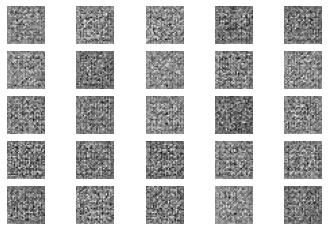

In [86]:
latent_dim = 100
model = define_generator(latent_dim)
n_samples = 25
X, _ = generate_fake_samples(model, latent_dim, n_samples)
for i in range(n_samples):
    pyplot.subplot(5, 5, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(X[i, :, :, 0], cmap='gray_r')

    
pyplot.show()

In [87]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    
    return model

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_30 (Sequential)   (None, 28, 28, 1)         1164289   
_________________________________________________________________
sequential_29 (Sequential)   (None, 1)                 40705     
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


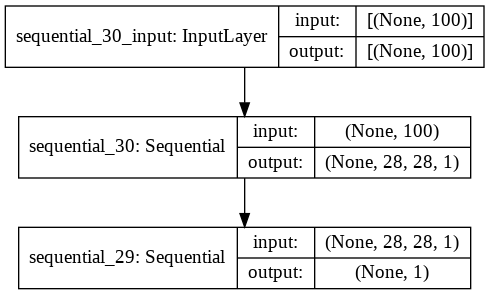

In [88]:
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
gan_model.summary()
plot_model(gan_model, to_file='gan_plot.png',
           show_shapes=True,
           show_layer_names=True)

In [89]:
def train_gan(gan_model, latent_dim, n_epochs=100, n_batch=256):
    for i in range(n_epochs):
        x_gan = generate_latent_points(latent_dim, n_batch)
        y_gan = ones((n_batch, 1))
        gan_model.train_on_batch(x_gan, y_gan)

In [90]:
def train(g_model, d_model, gan_model, dataset, latent_dim,
          n_epochs=1, n_batch=256):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)

    for i in range(n_epochs):
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset,
                                                   half_batch)
            X_fake, y_fake = generate_fake_samples(g_model,
                                                   latent_dim,
                                                   half_batch)
            
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
            d_loss, _ = d_model.train_on_batch(X, y)

            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)


            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1,
                                                  bat_per_epo,
                                                  d_loss, g_loss))

        if (i+1) % 10 == 0:
            summarize_performance(i, g_model,
                                  d_model, dataset,
                                  latent_dim)

In [91]:
def save_plot(examples, epoch, n=10):

    for i in range(n * n):
        pyplot.subplot(n, n, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')

    filename = 'generated_plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()

In [92]:
def summarize_performance(epoch, g_model, d_model,
                          dataset, latent_dim, n_samples=100):
  
    X_real, y_real = generate_real_samples(dataset, n_samples)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)

    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    filename = 'generator_model_%03d.h5' % (epoch + 1)
    g_model.save(filename)

In [93]:

latent_dim = 100
d_model = define_discriminator()

g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)

dataset = load_real_samples()
train(g_model, d_model, gan_model, dataset, latent_dim)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


>1, 1/234, d=0.661, g=0.802
>1, 2/234, d=0.656, g=0.812
>1, 3/234, d=0.647, g=0.837
>1, 4/234, d=0.644, g=0.857
>1, 5/234, d=0.635, g=0.871
>1, 6/234, d=0.628, g=0.883
>1, 7/234, d=0.623, g=0.899
>1, 8/234, d=0.624, g=0.899
>1, 9/234, d=0.625, g=0.891
>1, 10/234, d=0.628, g=0.877
>1, 11/234, d=0.630, g=0.847
>1, 12/234, d=0.639, g=0.809
>1, 13/234, d=0.646, g=0.779
>1, 14/234, d=0.654, g=0.753
>1, 15/234, d=0.653, g=0.733
>1, 16/234, d=0.654, g=0.722
>1, 17/234, d=0.650, g=0.713
>1, 18/234, d=0.646, g=0.706
>1, 19/234, d=0.641, g=0.703
>1, 20/234, d=0.638, g=0.701
>1, 21/234, d=0.630, g=0.698
>1, 22/234, d=0.630, g=0.697
>1, 23/234, d=0.616, g=0.696
>1, 24/234, d=0.609, g=0.696
>1, 25/234, d=0.605, g=0.696
>1, 26/234, d=0.591, g=0.696
>1, 27/234, d=0.582, g=0.697
>1, 28/234, d=0.575, g=0.697
>1, 29/234, d=0.567, g=0.698
>1, 30/234, d=0.556, g=0.698
>1, 31/234, d=0.550, g=0.699
>1, 32/234, d=0.540, g=0.700
>1, 33/234, d=0.535, g=0.701
>1, 34/234, d=0.523, g=0.702
>1, 35/234, d=0.511, g=

In [97]:
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
 
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input


def save_plot(examples, n):
    for i in range(n * n):
        pyplot.subplot(n, n, 1 + i)
        pyplot.axis('off')

        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()

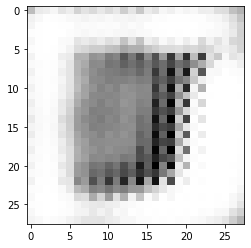

In [103]:
# generating image for point in latent space
from keras.models import load_model
from numpy import asarray
from matplotlib import pyplot

model = g_model
vector = asarray([[0.0 for _ in range(100)]])
X = model.predict(vector)

pyplot.imshow(X[0, :, :, 0], cmap='gray_r')
pyplot.show()

In [104]:
# variational autoencoder
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [105]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 7, 7, 64)     18496       conv2d_57[0][0]                  
__________________________________________________________________________________________________
flatten_20 (Flatten)            (None, 3136)         0           conv2d_58[0][0]                  
____________________________________________________________________________________________

In [106]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_38 (Dense)             (None, 3136)              9408      
_________________________________________________________________
reshape_9 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_18 (Conv2DT (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_19 (Conv2DT (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_20 (Conv2DT (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

In [107]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [108]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=1, batch_size=128)

547/547 [==============================] - 101s 183ms/step - loss: 258.0121 - reconstruction_loss: 208.5243 - kl_loss: 2.9123


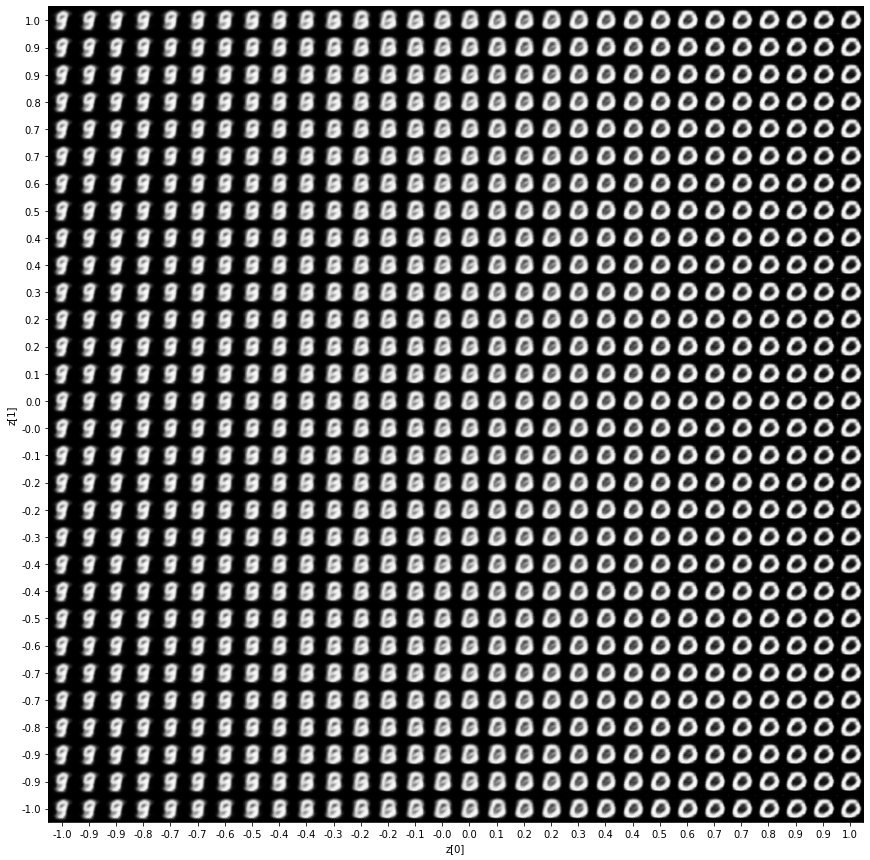

In [109]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

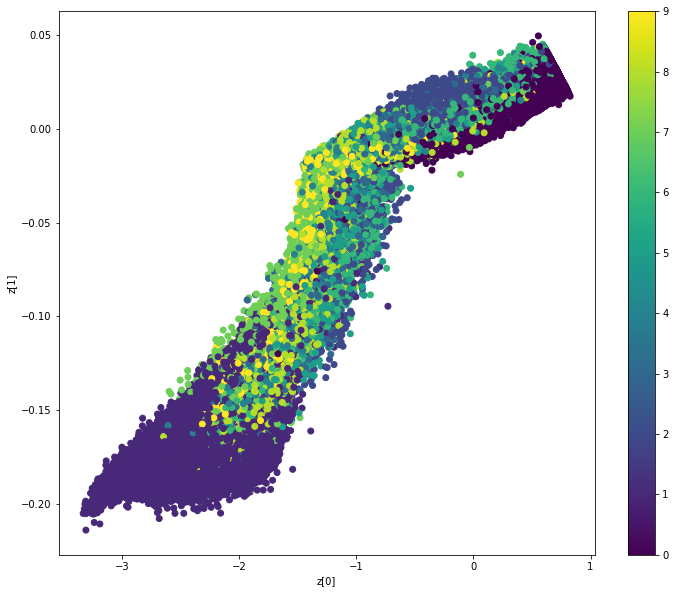

In [110]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

Sources: 
* https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/
* https://keras.io/examples/generative/vae/#variational-autoencoder
* https://keras.io/examples/generative/vae/
* https://keras.io/examples/generative/vae/#train-the-vae


